In [49]:
import time
from datetime import datetime, date, time, timedelta
import asyncio
import nest_asyncio
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from tastytrade import Account, Session, DXLinkStreamer
from tastytrade.dxfeed import Quote, Candle
from config import *

nest_asyncio.apply()

In [17]:
session=None
account=None

async def setup():
    global session, account
    # setup
    config = Config(test=True)
    session = Session(config.username, config.password, is_test=config.test)
    account = await Account.a_get_account(session, config.account_number)

    # account info
    balance = account.get_balances(session)
    positions = account.get_positions(session)
    history = account.get_history(session)

In [19]:
asyncio.run(setup())

In [159]:
async def stream():
    global session, account
    streamer = await DXLinkStreamer(session)
    candles = []
    queuelengths = []
    
    symbols = ["NVDA"]
    interval = "5m"
    start_time = datetime(2024,1,1,21,30,0)
    
    await streamer.subscribe_candle(symbols, interval, start_time)
    
    while len(candles) < 1000 or streamer._queues["Candle"].qsize() > 0:
        # input a rough estimate for how many data points will be required, and this will loop for that many iterations until the queue is empty
        candle = await streamer.get_event(Candle)
        candles.append(candle)
        queuelengths.append(streamer._queues["Candle"].qsize())
        if len(candles)%1000 ==0:
            print(len(candles))
    
    #candles = streamer._queues["Candle"]
    #print(candles)
    return candles, queuelengths

In [160]:
candles, queuelengths = asyncio.run(stream())

1000
2000
3000
4000
5000


In [161]:
times = [[datetime.fromtimestamp(candle.time/1000), candle.open, candle.high, candle.low, candle.close] for candle in candles]
df = pd.DataFrame(times, columns=["time", "open", "high", "low", "close"])

In [162]:
display(df)

,time,open,high,low,close
0,2025-02-08 04:58:00,129.865,130.0,129.815,129.87
1,2025-02-08 04:56:00,129.74,129.9,129.67,129.8602
2,2025-02-08 04:54:00,129.81,129.85,129.6,129.745
3,2025-02-08 04:52:00,129.58,129.82,129.535,129.8199
4,2025-02-08 04:50:00,129.38,129.64,129.38,129.5739
...,...,...,...,...,...
5261,2024-12-30 22:36:00,135.0242,135.57,134.58,135.56
5262,2024-12-30 22:34:00,134.375,135.06,134.225,135.01
5263,2024-12-30 22:32:00,135.09,135.18,134.02,134.36
5264,2024-12-30 22:30:00,134.83,135.62,134.41,135.056


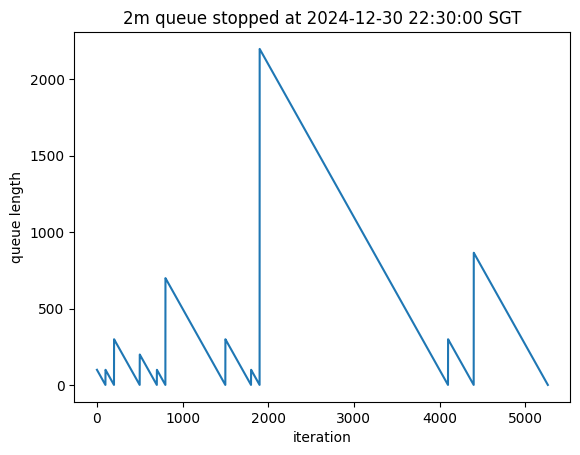

In [164]:
plt.plot(queuelengths)
plt.xlabel('iteration')
plt.ylabel('queue length')
plt.title('2m queue stopped at 2024-12-30 22:30:00 SGT')
plt.show()